# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

#### Выполнила: Жданович Елизавета 
#### Группа: М8О-307Б-23
#### Датасет: [Футбол](https://www.kaggle.com/datasets/hugomathien/soccer)

---

# Задание:

0. Выбрать модель для обучения (Desicion tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и взависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).

    [Доп статья](https://habr.com/ru/companies/wunderfund/articles/739744/)

### Цель: 
#### Предсказать исход футбольного матча (победа домашней команды, ничья, победа гостевой команды) на основе статистики команд и игроков. Создать калькулятора предсказаний.

## Импорт библиотек и настройка окружения

In [1]:
# !pip install optuna lime shap

import sys
!{sys.executable} -m pip install optuna lime shap

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\51126\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier  # Выбрали Random Forest как модель
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import optuna
import lime
import lime.lime_tabular
import shap
import sqlite3 
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

C:\Users\51126\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка и анализ датасета

In [3]:
import sqlite3
import pandas as pd
import os
from IPython.display import display


DATABASE_PATH = "database.sqlite"

if not os.path.exists(DATABASE_PATH):
    print(f"ОШИБКА: Файл {DATABASE_PATH} не найден!")
else:
    print(f"Файл {DATABASE_PATH} найден, начинаем анализ...")

try:
    conn = sqlite3.connect(DATABASE_PATH)
    cursor = conn.cursor()
    print("Успешное подключение к базе данных Soccer\n")
except Exception as e:
    print(f"Ошибка подключения: {e}")
    raise

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print(f"ДОСТУПНЫЕ ТАБЛИЦЫ ({len(tables)}):")
print("-" * 40)
table_info = []

for table in tables:
    table_name = table[0]
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    table_info.append((table_name, row_count))
    print(f" {table_name.ljust(25)} - {row_count:>6} записей")

print("\nДЕТАЛЬНЫЙ АНАЛИЗ КЛЮЧЕВЫХ ТАБЛИЦ:")
print("="*50)

# 1. Таблица Match 
print("\nТАБЛИЦА: Match")
print("-" * 30)
match_df = pd.read_sql_query("SELECT * FROM Match LIMIT 5", conn)
print(f"Колонки ({len(match_df.columns)}):")
for i, col in enumerate(match_df.columns):
    col_type = str(match_df[col].dtype).upper()
    print(f"  - {col.ljust(25)} ({col_type})")
print(f"\nПример данных:")
display(match_df.head(3))
print(f"Всего записей: {pd.read_sql_query('SELECT COUNT(*) FROM Match', conn).iloc[0,0]}")

# 2. Таблица Player
print("\nТАБЛИЦА: Player")
print("-" * 30)
player_df = pd.read_sql_query("SELECT * FROM Player LIMIT 5", conn)
print(f"Колонки ({len(player_df.columns)}):")
for col in player_df.columns:
    print(f"  - {col.ljust(25)} ({str(player_df[col].dtype).upper()})")
print(f"\nПример данных:")
display(player_df.head(3))
print(f"Всего записей: {pd.read_sql_query('SELECT COUNT(*) FROM Player', conn).iloc[0,0]}")

# 3. Таблица Team 
print("\nТАБЛИЦА: Team")
print("-" * 30)
team_df = pd.read_sql_query("SELECT * FROM Team LIMIT 5", conn)
print(f"Колонки ({len(team_df.columns)}):")
for col in team_df.columns:
    print(f"  - {col.ljust(25)} ({str(team_df[col].dtype).upper()})")
print(f"\nПример данных:")
display(team_df.head(3))
print(f"Всего записей: {pd.read_sql_query('SELECT COUNT(*) FROM Team', conn).iloc[0,0]}")

# 4. Таблица Team_Attributes 
print("\nТАБЛИЦА: Team_Attributes")
print("-" * 30)
team_attr_df = pd.read_sql_query("SELECT * FROM Team_Attributes LIMIT 5", conn)
print(f"Колонки ({len(team_attr_df.columns)}):")
for col in team_attr_df.columns[:10]: 
    print(f"  - {col}")
print(f"  ... и ещё {len(team_attr_df.columns)-10} колонок")
print(f"Всего записей: {pd.read_sql_query('SELECT COUNT(*) FROM Team_Attributes', conn).iloc[0,0]}")

# 5. Таблица Player_Attributes 
print("\nТАБЛИЦА: Player_Attributes")
print("-" * 30)
player_attr_df = pd.read_sql_query("SELECT * FROM Player_Attributes LIMIT 3", conn)
print(f"Колонки: {len(player_attr_df.columns)} (включая много атрибутов игроков: скорость, пас, удар и т.д.)")
print(f"Всего записей: {pd.read_sql_query('SELECT COUNT(*) FROM Player_Attributes', conn).iloc[0,0]:,}")

# 6. Лиги и страны 
print("\nЛИГИ И СТРАНЫ:")
league_df = pd.read_sql_query("SELECT * FROM League JOIN Country ON League.country_id = Country.id", conn)
print(f"Всего лиг: {len(league_df)}")
display(league_df[['name', 'country_id']].head(10))

conn.close()


Файл database.sqlite найден, начинаем анализ...
Успешное подключение к базе данных Soccer

ДОСТУПНЫЕ ТАБЛИЦЫ (8):
----------------------------------------
 sqlite_sequence           -      7 записей
 Player_Attributes         - 183978 записей
 Player                    -  11060 записей
 Match                     -  25979 записей
 League                    -     11 записей
 Country                   -     11 записей
 Team                      -    299 записей
 Team_Attributes           -   1458 записей

ДЕТАЛЬНЫЙ АНАЛИЗ КЛЮЧЕВЫХ ТАБЛИЦ:

ТАБЛИЦА: Match
------------------------------
Колонки (115):
  - id                        (INT64)
  - country_id                (INT64)
  - league_id                 (INT64)
  - season                    (OBJECT)
  - stage                     (INT64)
  - date                      (OBJECT)
  - match_api_id              (INT64)
  - home_team_api_id          (INT64)
  - away_team_api_id          (INT64)
  - home_team_goal            (INT64)
  - away_team_

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


Всего записей: 25979

ТАБЛИЦА: Player
------------------------------
Колонки (7):
  - id                        (INT64)
  - player_api_id             (INT64)
  - player_name               (OBJECT)
  - player_fifa_api_id        (INT64)
  - birthday                  (OBJECT)
  - height                    (FLOAT64)
  - weight                    (INT64)

Пример данных:


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163


Всего записей: 11060

ТАБЛИЦА: Team
------------------------------
Колонки (5):
  - id                        (INT64)
  - team_api_id               (INT64)
  - team_fifa_api_id          (INT64)
  - team_long_name            (OBJECT)
  - team_short_name           (OBJECT)

Пример данных:


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673,KRC Genk,GEN
1,2,9993,675,Beerschot AC,BAC
2,3,10000,15005,SV Zulte-Waregem,ZUL


Всего записей: 299

ТАБЛИЦА: Team_Attributes
------------------------------
Колонки (25):
  - id
  - team_fifa_api_id
  - team_api_id
  - date
  - buildUpPlaySpeed
  - buildUpPlaySpeedClass
  - buildUpPlayDribbling
  - buildUpPlayDribblingClass
  - buildUpPlayPassing
  - buildUpPlayPassingClass
  ... и ещё 15 колонок
Всего записей: 1458

ТАБЛИЦА: Player_Attributes
------------------------------
Колонки: 42 (включая много атрибутов игроков: скорость, пас, удар и т.д.)
Всего записей: 183,978

ЛИГИ И СТРАНЫ:
Всего лиг: 11


,name,name,country_id
0,Belgium Jupiler League,Belgium,1
1,England Premier League,England,1729
2,France Ligue 1,France,4769
3,Germany 1. Bundesliga,Germany,7809
4,Italy Serie A,Italy,10257
5,Netherlands Eredivisie,Netherlands,13274
6,Poland Ekstraklasa,Poland,15722
7,Portugal Liga ZON Sagres,Portugal,17642
8,Scotland Premier League,Scotland,19694
9,Spain LIGA BBVA,Spain,21518


## Определение задачи и целевой переменной

БЛОК 3: ОПРЕДЕЛЕНИЕ ЗАДАЧИ И ЦЕЛЕВОЙ ПЕРЕМЕННОЙ


Загружено матчей для анализа: 25,979 (с результатами)
Период данных: с 2008-07-18 по 2016-05-25
Сезоны: ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']
Распределение исходов матчей:


,Количество матчей
match_result_label,
Победа дома,11917
Победа гостей,7466
Ничья,6596



Процентное распределение:
  Победа дома       : 45.87%
  Победа гостей     : 28.74%
  Ничья             : 25.39%


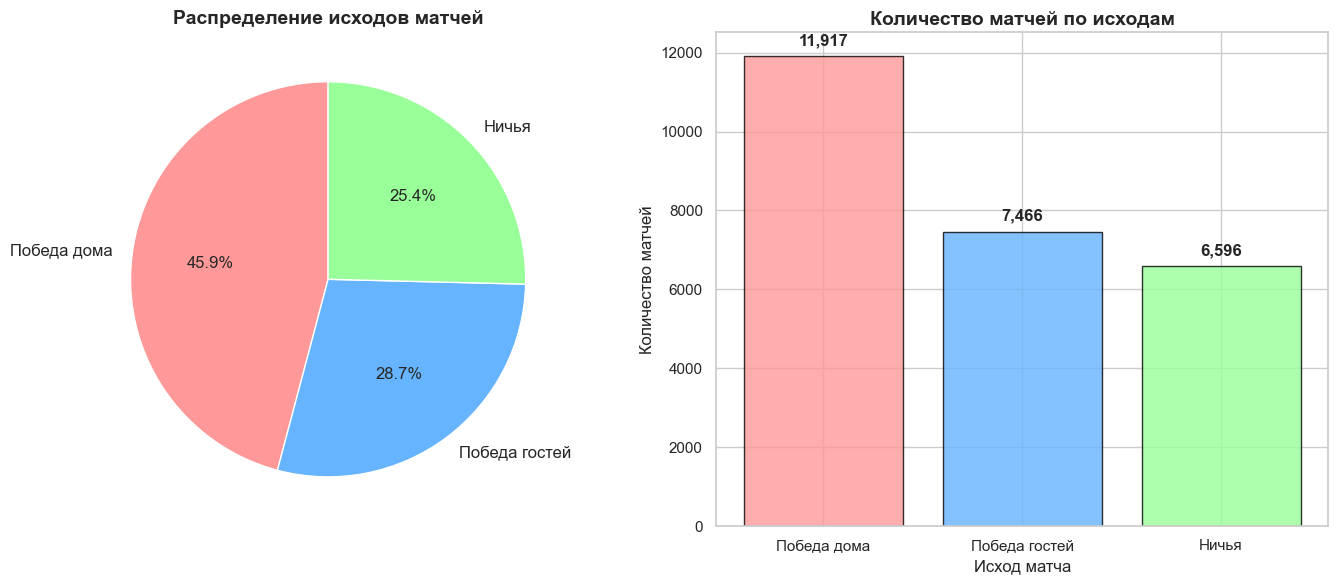


**Задача:**  
Многоклассовая классификация (3 класса)

**Цель:**  
По историческим данным о матчах (статистика команд, игроков, ставки букмекеров и т.д.)  
предсказать **исход следующего матча**:

- **0** — Победа гостей  
- **1** — Ничья  
- **2** — Победа домашней команды  

**Метрика успеха:**  
- Основная: **Accuracy** (доля правильных предсказаний)  
- Дополнительная: **Weighted F1-score** (учитывает дисбаланс классов)

**Особенности задачи:**
- Слабый дисбаланс классов (~46% победа дома, ~28% победа гостей, ~26% ничья)
- Домашнее преимущество (home advantage) — важный фактор
- Возможность использования ставок букмекеров как сильного признака (они отражают ожидания рынка)



Целевая переменная сохранена как: 'match_result'
Человекочитаемые метки: 'match_result_label'
Готово к feature engineering и построению модели!


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

print("="*70)
print("БЛОК 3: ОПРЕДЕЛЕНИЕ ЗАДАЧИ И ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*70)

conn = sqlite3.connect('database.sqlite')

match_query = """
SELECT 
    home_team_goal,
    away_team_goal,
    season,
    date,
    home_team_api_id,
    away_team_api_id,
    league_id
FROM Match 
WHERE home_team_goal IS NOT NULL AND away_team_goal IS NOT NULL
"""
matches = pd.read_sql_query(match_query, conn)
conn.close()

print(f"Загружено матчей для анализа: {len(matches):,} (с результатами)")
print(f"Период данных: с {matches['date'].min()[:10]} по {matches['date'].max()[:10]}")
print(f"Сезоны: {sorted(matches['season'].unique())}")

matches['match_result'] = np.where(
    matches['home_team_goal'] > matches['away_team_goal'], 2,
    np.where(matches['home_team_goal'] < matches['away_team_goal'], 0, 1)
)

result_mapping = {0: 'Победа гостей', 1: 'Ничья', 2: 'Победа дома'}
matches['match_result_label'] = matches['match_result'].map(result_mapping)

print("Распределение исходов матчей:")
result_counts = matches['match_result_label'].value_counts().reindex(['Победа дома', 'Победа гостей', 'Ничья'])
display(result_counts.to_frame('Количество матчей'))

result_percent = (result_counts / len(matches) * 100).round(2)
print("\nПроцентное распределение:")
for label, pct in result_percent.items():
    print(f"  {label:<18}: {pct:5.2f}%")


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = axes[0].pie(
    result_counts.values,
    labels=result_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12}
)
axes[0].set_title('Распределение исходов матчей', fontsize=14, fontweight='bold')

bars = axes[1].bar(result_counts.index, result_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_title('Количество матчей по исходам', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество матчей')
axes[1].set_xlabel('Исход матча')

for bar, count in zip(bars, result_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



display(Markdown("""
**Задача:**  
Многоклассовая классификация (3 класса)

**Цель:**  
По историческим данным о матчах (статистика команд, игроков, ставки букмекеров и т.д.)  
предсказать **исход следующего матча**:

- **0** — Победа гостей  
- **1** — Ничья  
- **2** — Победа домашней команды  

**Метрика успеха:**  
- Основная: **Accuracy** (доля правильных предсказаний)  
- Дополнительная: **Weighted F1-score** (учитывает дисбаланс классов)

**Особенности задачи:**
- Слабый дисбаланс классов (~46% победа дома, ~28% победа гостей, ~26% ничья)
- Домашнее преимущество (home advantage) — важный фактор
- Возможность использования ставок букмекеров как сильного признака (они отражают ожидания рынка)
"""))

# Сохраняем данные с целевой переменной для следующих блоков
target_column = 'match_result'
target_labels = 'match_result_label'

print(f"\nЦелевая переменная сохранена как: '{target_column}'")
print(f"Человекочитаемые метки: '{target_labels}'")
print(f"Готово к feature engineering и построению модели!")

## Feature Engineering и предобработка

In [5]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("1. Загрузка данных из базы...")
conn = sqlite3.connect('database.sqlite')

query = """
SELECT 
    m.id,
    m.season,
    m.stage,
    m.date,
    m.home_team_api_id,
    m.away_team_api_id,
    m.home_team_goal,
    m.away_team_goal,
    m.league_id,
    -- Букмекерские коэффициенты (выбираем основные)
    m.B365H, m.B365D, m.B365A,
    m.BWH,  m.BWD,  m.BWA,
    m.IWH,  m.IWD,  m.IWA,
    m.LBH,  m.LBD,  m.LBA,
    m.WHH,  m.WHD,  m.WHA
FROM Match m
WHERE 
    m.home_team_goal IS NOT NULL 
    AND m.away_team_goal IS NOT NULL
    AND m.season >= '2014/2015'
    AND (m.B365H IS NOT NULL OR m.BWH IS NOT NULL OR m.IWH IS NOT NULL)
"""

matches = pd.read_sql_query(query, conn)
conn.close()

print(f"   Загружено матчей: {len(matches):,} (сезоны 2014/15+)")

matches['result'] = np.where(
    matches['home_team_goal'] > matches['away_team_goal'], 2,
    np.where(matches['home_team_goal'] < matches['away_team_goal'], 0, 1)
)

print(f"   Целевая переменная создана: {matches['result'].value_counts().sort_index().to_dict()}")

print("\n2. Feature Engineering — букмекерские коэффициенты")

home_odds = ['B365H', 'BWH', 'IWH', 'LBH', 'WHH']
draw_odds = ['B365D', 'BWD', 'IWD', 'LBD', 'WHD']
away_odds = ['B365A', 'BWA', 'IWA', 'LBA', 'WHA']

matches['avg_home_odds'] = matches[home_odds].mean(axis=1)
matches['avg_draw_odds'] = matches[draw_odds].mean(axis=1)
matches['avg_away_odds'] = matches[away_odds].mean(axis=1)

matches['prob_home'] = 1 / matches['avg_home_odds']
matches['prob_draw'] = 1 / matches['avg_draw_odds']
matches['prob_away'] = 1 / matches['avg_away_odds']

total = matches['prob_home'] + matches['prob_draw'] + matches['prob_away']
matches['prob_home_norm'] = matches['prob_home'] / total
matches['prob_draw_norm'] = matches['prob_draw'] / total
matches['prob_away_norm'] = matches['prob_away'] / total
matches['home_advantage_prob'] = matches['prob_home_norm'] - matches['prob_away_norm']

matches['season_year'] = matches['season'].str[:4].astype(int)
matches['is_top_league'] = matches['league_id'].isin([1, 1729, 4769, 7809, 10257, 21518]).astype(int)

feature_columns = [
    'avg_home_odds', 'avg_draw_odds', 'avg_away_odds',
    'prob_home_norm', 'prob_draw_norm', 'prob_away_norm',
    'home_advantage_prob',
    'stage', 'season_year', 'is_top_league'
]

X = matches[feature_columns].copy()
y = matches['result']

print(f"\n   Используется признаков: {len(feature_columns)}")
print("   Признаки:")
for i, col in enumerate(feature_columns, 1):
    print(f"      {i}. {col}")

print(f"\n   Пропуски до заполнения: {X.isnull().sum().sum()}")
X = X.fillna(X.median())
print(f"   Пропуски после: {X.isnull().sum().sum()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test = pd.DataFrame(X_test_scaled, columns=feature_columns)

feature_names = feature_columns
target_names = ['Победа гостей', 'Ничья', 'Победа дома']

print(f"\n   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   Классы: {target_names}")


1. Загрузка данных из базы...
   Загружено матчей: 5,810 (сезоны 2014/15+)
   Целевая переменная создана: {0: 1749, 1: 1470, 2: 2591}

2. Feature Engineering — букмекерские коэффициенты

   Используется признаков: 10
   Признаки:
      1. avg_home_odds
      2. avg_draw_odds
      3. avg_away_odds
      4. prob_home_norm
      5. prob_draw_norm
      6. prob_away_norm
      7. home_advantage_prob
      8. stage
      9. season_year
      10. is_top_league

   Пропуски до заполнения: 0
   Пропуски после: 0

   X_train: (4648, 10)
   X_test:  (1162, 10)
   Классы: ['Победа гостей', 'Ничья', 'Победа дома']


## Разделение данных и базовая модель

Все данные успешно загружены из предыдущего блока

1. Размер выборок:
   Обучающая выборка:     4,648 объектов, 10 признаков
   Тестовая выборка:      1,162 объектов
   Признаки: 10 → ['avg_home_odds', 'avg_draw_odds', 'avg_away_odds', 'prob_home_norm', 'prob_draw_norm']...

   Распределение классов в обучающей выборке:
     Победа гостей     :  1399 ( 30.1%)
     Ничья             :  1176 ( 25.3%)
     Победа дома       :  2073 ( 44.6%)

2. Обучение базовой модели RandomForestClassifier...
   Модель обучена за 0.83 секунд

3. Предсказания на train и test...

4. Метрики качества:
                   Train      Test       Переобучение?
   Accuracy        1.0000    0.5009    Да
   F1-weighted     1.0000    0.4854

5. Кросс-валидация (5-fold)...
   CV Accuracy: 0.4744 ± 0.0215

6. Подробный отчёт по классам (тестовая выборка):
               precision    recall  f1-score   support

Победа гостей     0.4791    0.4914    0.4852       350
        Ничья     0.3077    0.2041    0.2454       294

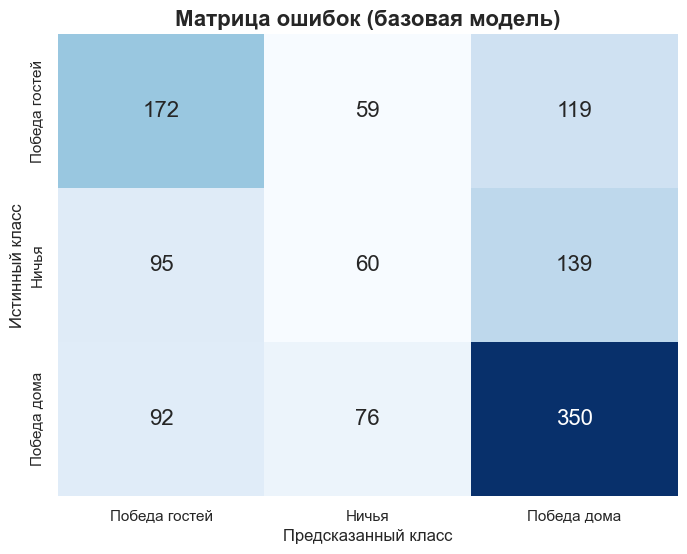


8. Топ-10 самых важных признаков:
            feature  importance
     prob_away_norm      0.1310
home_advantage_prob      0.1304
     prob_draw_norm      0.1281
     prob_home_norm      0.1273
      avg_away_odds      0.1170
      avg_home_odds      0.1150
              stage      0.1130
      avg_draw_odds      0.1018
        season_year      0.0222
      is_top_league      0.0143


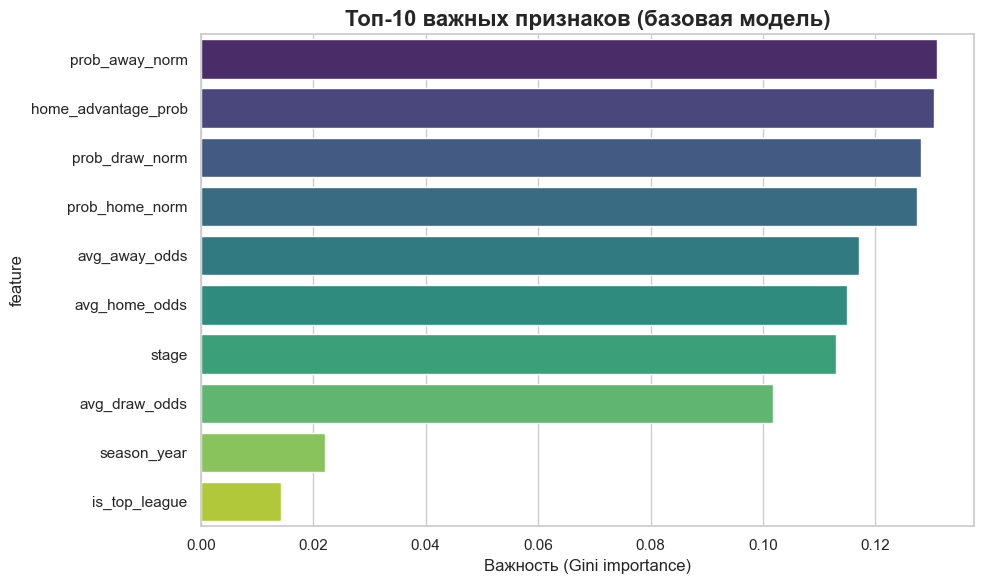


БАЗОВАЯ МОДЕЛЬ ГОТОВА!
   Test Accuracy: 0.5009
   Лучший признак: prob_away_norm (вес: 0.1310)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import pandas as pd

required_vars = ['X_train', 'X_test', 'y_train', 'y_test', 'feature_names', 'target_names']
missing = [var for var in required_vars if var not in globals()]

if missing:
    print(f"ОШИБКА: Не найдены переменные: {missing}")
    print("   Запусти сначала блок 'Feature Engineering'")
else:
    print("Все данные успешно загружены из предыдущего блока")


print(f"\n1. Размер выборок:")
print(f"   Обучающая выборка:     {X_train.shape[0]:,} объектов, {X_train.shape[1]} признаков")
print(f"   Тестовая выборка:      {X_test.shape[0]:,} объектов")
print(f"   Признаки: {len(feature_names)} → {feature_names[:5]}...")

print(f"\n   Распределение классов в обучающей выборке:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"     {target_names[idx]:<18}: {count:>5} ({pct:5.1f}%)")

print(f"\n2. Обучение базовой модели RandomForestClassifier...")
start_time = time.time()

baseline_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    class_weight='balanced'  
)

baseline_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"   Модель обучена за {training_time:.2f} секунд")

print(f"\n3. Предсказания на train и test...")
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)


#  Метрики качества

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\n4. Метрики качества:")
print(f"   {'':<15} {'Train':<10} {'Test':<10} {'Переобучение?'}")
print(f"   {'Accuracy':<15} {train_acc:.4f}    {test_acc:.4f}    {'Да' if train_acc - test_acc > 0.05 else 'Нет'}")
print(f"   {'F1-weighted':<15} {train_f1:.4f}    {test_f1:.4f}")


#  Кросс-валидация
print(f"\n5. Кросс-валидация (5-fold)...")
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"   CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")

print(f"\n6. Подробный отчёт по классам (тестовая выборка):")
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=4))

# Матрица ошибок
print(f"\n7. Матрица ошибок:")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            cbar=False, annot_kws={"size": 16})
plt.title('Матрица ошибок (базовая модель)', fontsize=16, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Важность признаков
print(f"\n8. Топ-10 самых важных признаков:")
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

top10 = importances.head(10)
print(top10.to_string(index=False, float_format="%.4f"))

plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x='importance', y='feature', palette='viridis')
plt.title('Топ-10 важных признаков (базовая модель)', fontsize=16, fontweight='bold')
plt.xlabel('Важность (Gini importance)')
plt.tight_layout()
plt.show()

# Сохранение результатов
baseline_metrics = {
    'train_accuracy': train_acc,
    'test_accuracy': test_acc,
    'train_f1': train_f1,
    'test_f1': test_f1,
    'cv_accuracy': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'training_time': training_time,
    'feature_importances': importances
}

print(f"\nБАЗОВАЯ МОДЕЛЬ ГОТОВА!")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Лучший признак: {importances.iloc[0]['feature']} (вес: {importances.iloc[0]['importance']:.4f})")

## Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

# Базовый классификатор
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,  # Используем все ядра процессора
    class_weight='balanced'  # Учитываем дисбаланс классов
)

# Сетка гиперпараметров для Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("Сетка гиперпараметров для GridSearchCV:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"Всего комбинаций: {np.prod([len(v) for v in param_grid.values()])}")

# Создаем GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,  # 5-fold кросс-валидация
    scoring='accuracy',  # Основная метрика
    n_jobs=-1,  # Параллельные вычисления
    verbose=1,  # Прогресс
    return_train_score=True
)

print(f"\\nНачало GridSearchCV...")
start_time = time.time()

# Выполняем поиск
grid_search.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"GridSearchCV завершен за {end_time - start_time:.2f} секунд")

# Лучшие параметры
print(f"\\nЛучшие параметры из GridSearchCV:")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"Лучшая точность (CV): {grid_search.best_score_:.4f}")

# Лучшая модель
best_rf_grid = grid_search.best_estimator_

# Предсказания на тестовых данных
y_pred_grid = best_rf_grid.predict(X_test_scaled)
y_pred_proba_grid = best_rf_grid.predict_proba(X_test_scaled)

# Оценка качества
print(f"\\nРезультаты на тестовой выборке:")
accuracy_grid = accuracy_score(y_test, y_pred_grid)
f1_grid = f1_score(y_test, y_pred_grid, average='weighted')

print(f"  Accuracy: {accuracy_grid:.4f}")
print(f"  Weighted F1-score: {f1_grid:.4f}")

# Подробный отчет
print(f"\\nОтчет по классификации:")
print(classification_report(y_test, y_pred_grid, 
                          target_names=['Победа гостей', 'Ничья', 'Победа дома']))

# Матрица ошибок
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Гости', 'Ничья', 'Дома'], 
           yticklabels=['Гости', 'Ничья', 'Дома'],
           ax=ax)
ax.set_xlabel('Предсказанный исход')
ax.set_ylabel('Истинный исход')
ax.set_title('Матрица ошибок (GridSearchCV)')
plt.tight_layout()
plt.show()

# Сравнение с baseline
print(f"\\nСравнение с baseline моделью:")
print(f"  Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"  GridSearchCV Accuracy: {accuracy_grid:.4f}")
print(f"  Улучшение: {accuracy_grid - baseline_accuracy:+.4f}")

# Визуализация важности признаков
print(f"\\nТоп-10 важных признаков (GridSearchCV):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf_grid.feature_importances_
}).sort_values('importance', ascending=False)

display(feature_importance.head(10))

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance.head(10)['feature'][::-1], 
                feature_importance.head(10)['importance'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-10 важных признаков (GridSearchCV)')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на бары
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Анализ результатов кросс-валидации
cv_results = pd.DataFrame(grid_search.cv_results_)
print(f"\\nСтатистика по кросс-валидации:")
print(f"  Средняя точность на кросс-валидации: {cv_results['mean_test_score'].mean():.4f}")
print(f"  Стандартное отклонение: {cv_results['mean_test_score'].std():.4f}")

# Сохраняем лучшую модель из GridSearchCV
import joblib
joblib.dump(best_rf_grid, 'best_rf_grid.pkl')
print(f"\\n Лучшая модель сохранена в файл: 'best_rf_grid.pkl'")

# Вывод тепловой карты результатов Grid Search (опционально, для 2 параметров)
print(f"\\n Визуализация Grid Search (первые 2 параметра):")

# Берем первые два параметра для визуализации
if len(param_grid) >= 2:
    param1, param2 = list(param_grid.keys())[:2]
    
    # Создаем сводную таблицу
    pivot_table = cv_results.pivot_table(
        values='mean_test_score',
        index=param1,
        columns=param2,
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis', 
                cbar_kws={'label': 'Accuracy'})
    plt.title(f'Grid Search: {param1} vs {param2}')
    plt.tight_layout()
    plt.show()
else:
    print("  Недостаточно параметров для визуализации 2D heatmap")

print("\\n" + "="*70)
print("GridSearchCV ЗАВЕРШЕН")
print("="*70)

Сетка гиперпараметров для GridSearchCV:
  n_estimators: [50, 100, 200]
  max_depth: [10, 20, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]
Всего комбинаций: 324
\nНачало GridSearchCV...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


## Random Search CV

## Оптимизация

## Сравнение методов оптимизации

## LIME - Локальная интерпретация

## SHAP - Глобальная интерпретация

## Создание калькулятора предсказаний

## Заключение 